### Imports

In [1]:
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

***

The goal of this notebook is to introduce deep neural networks (DNNs) and convolutional neural networks (CNNs) using the high-level Keras package and to become familiar with how to choose its architecture, cost function, and optimizer in Keras. We will also learn how to train neural networks.

We will work with the MNIST dataset of hand written digits. The goal is to find a statistical model which recognizes and distinguishes between the ten handwritten digits (0-9).

The MNIST dataset comprises handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ nuances of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic classification task. 

In this Notebook, we show how to use the Keras python package to tackle the MNIST problem with the help of deep neural networks.

## Creating DNNs with Keras

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

We would like to emphasize that, while it is always possible to view steps 1-5 as independent of the particular task we are trying to solve, it is only when they are put together in ***step 6*** that the real gain of using Deep Learning is revealed, compared to less sophisticated methods such as the regression models. With this remark in mind, we shall focus predominantly on steps 1-5 below. We show how one can use grid search methods to find optimal hyperparameters in ***step 6***.

### Step 1: Load and Process the Data

Keras knows to download automatically the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape ($({\mathrm{N_{samples}}}, {\mathrm{N_{features}}})$). 

The size of each sample, i.e. the number of bare features used is N_features (whis is 784 because we have a $28 \times 28$ pixel grid), while the number of potential classification categories is "num_classes" (which is 10, number of digits).

Each pixel
contains a greyscale value quantified by an integer between
0 and 255. To standardize the dataset, we normalize
the input data in the interval [0, 1]. 

In [2]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
seed=0
np.random.seed(seed) # fix random seed
tf.set_random_seed(seed)

from keras.datasets import mnist

# input image dimensions
num_classes = 10 # 10 digits

img_rows, img_cols = 28, 28 # number of pixels 

# the data, shuffled and split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train[:40000]
Y_train = Y_train[:40000]

# reshape data, depending on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
    
# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255


Using TensorFlow backend.


<span style="color:blue"> <i> First we make a plot of one MNIST digit (2D plot using X data - we reshape it into a $28 \times 28$ matrix) and label it (which digit does it correspond to?). </i></span> <br>

label is  5


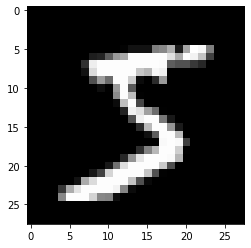

In [3]:
X_train_0 = X_train[0].reshape((28, 28))

plt.imshow(X_train_0, cmap=plt.cm.gray)
print('label is ', Y_train[0])

Last, we cast the label vectors $y$ to binary class matrices (a.k.a. one-hot format).

In [4]:
# convert class vectors to binary class matrices

print("before conversion - ")
print("y vector : ", Y_train[0:10])

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

print("after conversion - ")
print("y vector : ", Y_train[0:10])

before conversion - 
y vector :  [5 0 4 1 9 2 1 3 1 4]
after conversion - 
y vector :  [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Here in this template, we use 40000 training samples and 10000 test samples. Remember that we preprocessed data into the shape $({\mathrm{N_{samples}}}, {\mathrm{N_{features}}})$.

In [5]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (40000, 784)
Y_train shape: (40000, 10)

40000 train samples
10000 test samples


### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one.

Let us create an instance of Keras' `Sequential()` class, called `model`. As the name suggests, this class allows us to build DNNs layer by layer. (https://keras.io/getting-started/sequential-model-guide/)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# instantiate model
model = Sequential()

We use the `add()` method to attach layers to our model. For the purposes of our introductory example, it suffices to focus on `Dense` layers for simplicity. (https://keras.io/layers/core/) Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`.

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

First, add a `Dense` layer with 400 output neurons and `relu` activation function.

In [7]:
model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))

Add another layer with 100 output neurons. Then, we will apply "dropout," a regularization scheme that has been widely adopted in the neural networks literature: during the training procedure neurons
are randomly “dropped out” of the neural network with some
probability $p$ giving rise to a thinned network. It prevents overfitting by reducing spurious correlations between neurons within the network by introducing
a randomization procedure.

In [8]:
model.add(Dense(100, activation='relu'))
# apply dropout with rate 0.5
model.add(Dropout(0.5))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Lastly, we need to add a soft-max layer since we have a multi-class output.

In [9]:
model.add(Dense(num_classes, activation='softmax'))

### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module (https://keras.io/optimizers/), but we could use `Adam()` or any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. 

While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. 

To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [10]:
# compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])



Instructions for updating:
keep_dims is deprecated, use keepdims instead



### Step 4: Train the model

We train our DNN in minibatches. Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. 

(The number of epochs is the number of complete passes through the training dataset, and the batch size is a number of samples propagated through the network before the model is updated.)

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or validation data. To monitor the training procedure for every epoch, we set `verbose=True`. 

Let us set `batch_size` = 64 and `epochs` = 10.

In [11]:
# training parameters
batch_size = 64
epochs = 10

# train DNN and store training info in history
history=model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 40000 samples, validate on 10000 samples
Epoch 1/10




40000/40000 [==============================] - 3s - loss: 1.2014 - acc: 0.6446 - val_loss: 0.5088 - val_acc: 0.8838
Epoch 2/10
40000/40000 [==============================] - 2s - loss: 0.5894 - acc: 0.8317 - val_loss: 0.3645 - val_acc: 0.9065
Epoch 3/10
40000/40000 [==============================] - 3s - loss: 0.4755 - acc: 0.8649 - val_loss: 0.3081 - val_acc: 0.9194
Epoch 4/10
40000/40000 [==============================] - 3s - loss: 0.4101 - acc: 0.8813 - val_loss: 0.2755 - val_acc: 0.9243
Epoch 5/10
40000/40000 [==============================] - 3s - loss: 0.3716 - acc: 0.8977 - val_loss: 0.2526 - val_acc: 0.9289
Epoch 6/10
40000/40000 [==============================] - 2s - loss: 0.3445 - acc: 0.9030 - val_

### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

 9280/10000 [==========================>...] - ETA: 0sTest loss: 0.18727896657288073
Test accuracy: 0.9458


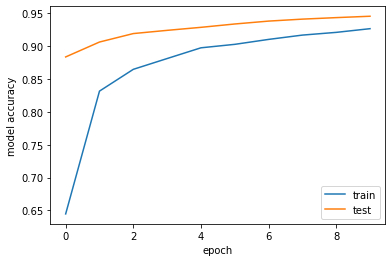

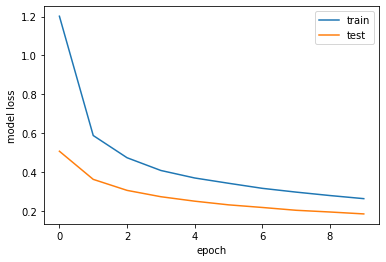

In [12]:
# evaluate model
score = model.evaluate(X_test, Y_test, verbose=1)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

Last, we show how to use the grid search option of scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to optimize the 
hyperparameters of our model.

First, define a function for crating a DNN:

In [18]:
def create_DNN(optimizer=keras.optimizers.Adam()):
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

With epochs = 1 and batch_size = 64, do grid search over the following optimization schemes: ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'].

In [19]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

batch_size = 64
epochs = 1
model_gridsearch = KerasClassifier(build_fn=create_DNN, 
                        epochs=epochs, batch_size=batch_size, verbose=1)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# define parameter dictionary
param_grid = dict(optimizer=optimizer)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,Y_train)

Epoch 1/1
10000/10000 [==============================] - 0s     
Epoch 1/1
10000/10000 [==============================] - 0s     
Epoch 1/1
40000/40000 [==============================] - 5s - loss: 0.3201 - acc: 0.9064     


Show the mean test score of all optimization schemes and determine which scheme gives the best accuracy.

In [20]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.951900 using {'optimizer': 'Nadam'}
0.850650 (0.013675) with: {'optimizer': 'SGD'}
0.946125 (0.001404) with: {'optimizer': 'RMSprop'}
0.946725 (0.003144) with: {'optimizer': 'Adagrad'}
0.925775 (0.002659) with: {'optimizer': 'Adadelta'}
0.946750 (0.001861) with: {'optimizer': 'Adam'}
0.935300 (0.002652) with: {'optimizer': 'Adamax'}
0.951900 (0.003367) with: {'optimizer': 'Nadam'}


<span style="color:blue"> <i>Then we create a DNN with one Dense layer having 200 output neurons. We do the grid search over any 5 different activation functions from https://keras.io/activations/. Let epochs = 1, batches = 64, p_dropout=0.5, and optimizer=keras.optimizers.Adam().  </i></span> <br>

In [16]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


activation = ['relu', 'tanh', 'elu', 'sigmoid', 'softmax']
def create_DNN_2(activation=activation):
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model
    
batch_size = 64
epochs = 1
model_gridsearch = KerasClassifier(build_fn=create_DNN_2, 
                        epochs=epochs, batch_size=batch_size, verbose=1)

# define parameter dictionary
param_grid = dict(activation=activation)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,Y_train)   
    
    



Epoch 1/1
10000/10000 [==============================] - 0s     
Epoch 1/1
10000/10000 [==============================] - 0s     
Epoch 1/1
10000/10000 [==============================] - 0s     
Epoch 1/1
40000/40000 [==============================] - 4s - loss: 0.3700 - acc: 0.8905     


In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.939825 using {'activation': 'relu'}
0.939825 (0.002309) with: {'activation': 'relu'}
0.915075 (0.006569) with: {'activation': 'tanh'}
0.912975 (0.003839) with: {'activation': 'elu'}
0.901950 (0.003238) with: {'activation': 'sigmoid'}
0.805725 (0.056667) with: {'activation': 'softmax'}


<span style="color:blue"> <i> Now, do the grid search over different combination of batch sizes (10, 30, 50, 100) and number of epochs (1, 2, 5). We use the activation function that gave us the highest accuracy.  </i></span> <br>

In [7]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [7]:
def create_DNN_4(activation='relu'):
    model = Sequential()
    model.add(Dense(20,input_shape=(img_rows*img_cols,), activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model



In [6]:
act = ['relu', 'tanh', 'elu', 'sigmoid', 'softmax']


model_gridsearch = KerasClassifier(build_fn=create_DNN_4, verbose=1)

    # define parameter dictionary

batch_size = [10, 30, 50, 100]
epochs = [1, 2, 5]
activation = ['relu']

param_grid = dict(batch_size=batch_size, epochs=epochs, activation = activation)

    # call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train,Y_train)
    
Score_relu = [grid_result.best_score_, grid_result.best_params_]
    
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means_relu = grid_result.cv_results_['mean_test_score']
stds_relu = grid_result.cv_results_['std_test_score']
params_relu = grid_result.cv_results_['params']





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/1




26666/26666 [==============================] - 6s - loss: 1.0427 - acc: 0.6350     
Epoch 2/2
26667/26667 [==============================] - 7s - loss: 0.9566 - acc: 0.6793     
Epoch 2/2
26667/26667 [==============================] - 8s - loss: 0.9820 - acc: 0.6577     
Epoch 2/2
26666/26666 [==============================] - 6s - loss: 1.0201 - acc: 0.6517     
Epoch 2/5
26666/26666 [==============================] - 6s - loss: 0.7666 - acc: 0.7409     
Epoch 3/5
26666/26666 [==============================] - 6s - loss: 0.7082 - acc: 0.7579     
Epoch 4/5
26666/26666 [==

In [14]:
print('means test score of each case with relu')
for mean, stdev, param in zip(means_relu, stds_relu, params_relu):
    print("%f (%f) with: %r" % (mean, stdev, param))

means test score of each case with relu
0.889925 (0.004422) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 1}
0.903850 (0.002809) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 2}
0.914275 (0.001474) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 5}
0.886175 (0.006052) with: {'activation': 'relu', 'batch_size': 30, 'epochs': 1}
0.903750 (0.002217) with: {'activation': 'relu', 'batch_size': 30, 'epochs': 2}
0.913800 (0.002882) with: {'activation': 'relu', 'batch_size': 30, 'epochs': 5}
0.876300 (0.008576) with: {'activation': 'relu', 'batch_size': 50, 'epochs': 1}
0.897000 (0.006627) with: {'activation': 'relu', 'batch_size': 50, 'epochs': 2}
0.908025 (0.002607) with: {'activation': 'relu', 'batch_size': 50, 'epochs': 5}
0.864050 (0.005912) with: {'activation': 'relu', 'batch_size': 100, 'epochs': 1}
0.889475 (0.002531) with: {'activation': 'relu', 'batch_size': 100, 'epochs': 2}
0.908125 (0.000744) with: {'activation': 'relu', 'batch_size': 100, 'epochs': 

In [12]:
print("Best with %r: %f using %s" % ('relu', Score_relu[0], Score_relu[0]))

Best with 'relu': 0.914275 using 0.9142749927327037


In [15]:
act = ['relu', 'tanh', 'elu', 'sigmoid', 'softmax']


model_gridsearch = KerasClassifier(build_fn=create_DNN_4, verbose=1)

    # define parameter dictionary

batch_size = [10, 30, 50, 100]
epochs = [1, 2, 5]
activation = ['tanh']

param_grid = dict(batch_size=batch_size, epochs=epochs, activation = activation)

    # call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train,Y_train)
    
Score_tanh = [grid_result.best_score_, grid_result.best_params_]
    
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means_tanh = grid_result.cv_results_['mean_test_score']
stds_tanh = grid_result.cv_results_['std_test_score']
params_tanh = grid_result.cv_results_['params']

Epoch 1/1
26666/26666 [==============================] - 9s - loss: 0.7577 - acc: 0.7792     
Epoch 2/2
26667/26667 [==============================] - 9s - loss: 0.7438 - acc: 0.7841     
Epoch 2/2
26667/26667 [==============================] - 9s - loss: 0.7671 - acc: 0.7732     
Epoch 2/2
26666/26666 [==============================] - 9s - loss: 0.7497 - acc: 0.7790     
Epoch 2/5
26666/26666 [==============================] - 7s - loss: 0.5347 - acc: 0.8405     
Epoch 3/5
26666/26666 [==============================] - 8s - loss: 0.5010 - acc: 0.8528     
Epoch 4/5
26666/26666 [==============================] - 7s - loss: 0.4849 - acc: 0.8548     
Epoch 5/5
26667/26667 [==============================] - 11s - loss: 0.7449 - acc: 0.7797    
Epoch 2/5
26667/26667 [==============================] - 6s - loss: 0.5334 - acc: 0.8410     
Epoch 3/5
26667/26667 [==============================] - 7s - loss: 0.5025 - acc: 0.8498     
Epoch 4/5
26667/26667 [==============================] - 6s 

In [16]:
print('means test score of each case with tanh')
for mean, stdev, param in zip(means_tanh, stds_tanh, params_tanh):
    print("%f (%f) with: %r" % (mean, stdev, param))

means test score of each case with tanh
0.898450 (0.003674) with: {'activation': 'tanh', 'batch_size': 10, 'epochs': 1}
0.905675 (0.005771) with: {'activation': 'tanh', 'batch_size': 10, 'epochs': 2}
0.913950 (0.003750) with: {'activation': 'tanh', 'batch_size': 10, 'epochs': 5}
0.891700 (0.005177) with: {'activation': 'tanh', 'batch_size': 30, 'epochs': 1}
0.902550 (0.004015) with: {'activation': 'tanh', 'batch_size': 30, 'epochs': 2}
0.911550 (0.003491) with: {'activation': 'tanh', 'batch_size': 30, 'epochs': 5}
0.883750 (0.007857) with: {'activation': 'tanh', 'batch_size': 50, 'epochs': 1}
0.899200 (0.004641) with: {'activation': 'tanh', 'batch_size': 50, 'epochs': 2}
0.909975 (0.001752) with: {'activation': 'tanh', 'batch_size': 50, 'epochs': 5}
0.875075 (0.007555) with: {'activation': 'tanh', 'batch_size': 100, 'epochs': 1}
0.893025 (0.004453) with: {'activation': 'tanh', 'batch_size': 100, 'epochs': 2}
0.906900 (0.002931) with: {'activation': 'tanh', 'batch_size': 100, 'epochs': 

In [33]:
print("Best with %r: %f using %s" % ('tanh', Score_tanh[0], Score_tanh[0]))

Best with 'tanh': 0.913950 using 0.913949992544949


In [8]:
act = ['relu', 'tanh', 'elu', 'sigmoid', 'softmax']



model_gridsearch = KerasClassifier(build_fn=create_DNN_4, verbose=1)

    # define parameter dictionary

batch_size = [10, 30, 50, 100]
epochs = [1, 2, 5]
activation = ['elu']

param_grid = dict(batch_size=batch_size, epochs=epochs, activation = activation)

    # call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train,Y_train)
    
Score_elu = [grid_result.best_score_, grid_result.best_params_]
    
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means_elu = grid_result.cv_results_['mean_test_score']
stds_elu = grid_result.cv_results_['std_test_score']
params_elu = grid_result.cv_results_['params']

WARNING  | module_wrapper.py:139 | From /srv/app/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:442: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

WARNING  | module_wrapper.py:139 | From /srv/app/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3543: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

WARNING  | deprecation.py:506 | From /srv/app/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2888: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
WARNING  | module_wrapper.py:139 | From /srv/app/venv/lib/python3.6/site-packages/keras/optimizers.py:711: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

WARNING  | deprecation.py:506

Epoch 1/1
26666/26666 [==============================] - 6s - loss: 0.7520 - acc: 0.7668     
Epoch 2/2
26667/26667 [==============================] - 8s - loss: 0.7351 - acc: 0.7765     
Epoch 2/2
26667/26667 [==============================] - 8s - loss: 0.7326 - acc: 0.7783     
Epoch 2/2
26666/26666 [==============================] - 8s - loss: 0.7595 - acc: 0.7673     
Epoch 2/5
26666/26666 [==============================] - 7s - loss: 0.5603 - acc: 0.8305     
Epoch 3/5
26666/26666 [==============================] - 7s - loss: 0.5140 - acc: 0.8476     
Epoch 4/5
26666/26666 [==============================] - 7s - loss: 0.4956 - acc: 0.8512     
Epoch 5/5
26667/26667 [==============================] - 6s - loss: 0.7790 - acc: 0.7647     
Epoch 2/5
26667/26667 [==============================] - 6s - loss: 0.5511 - acc: 0.8344     
Epoch 3/5
26667/26667 [==============================] - 6s - loss: 0.5158 - acc: 0.8451     
Epoch 4/5
26667/26667 [==============================] - 6s 

In [9]:
print('means test score of each case with tanh')
for mean, stdev, param in zip(means_elu, stds_elu, params_elu):
    print("%f (%f) with: %r" % (mean, stdev, param))

means test score of each case with tanh
0.897150 (0.003281) with: {'activation': 'elu', 'batch_size': 10, 'epochs': 1}
0.907650 (0.001236) with: {'activation': 'elu', 'batch_size': 10, 'epochs': 2}
0.917650 (0.003197) with: {'activation': 'elu', 'batch_size': 10, 'epochs': 5}
0.890850 (0.006556) with: {'activation': 'elu', 'batch_size': 30, 'epochs': 1}
0.904575 (0.005457) with: {'activation': 'elu', 'batch_size': 30, 'epochs': 2}
0.914575 (0.004020) with: {'activation': 'elu', 'batch_size': 30, 'epochs': 5}
0.882775 (0.007863) with: {'activation': 'elu', 'batch_size': 50, 'epochs': 1}
0.901575 (0.005130) with: {'activation': 'elu', 'batch_size': 50, 'epochs': 2}
0.911125 (0.003150) with: {'activation': 'elu', 'batch_size': 50, 'epochs': 5}
0.872775 (0.002362) with: {'activation': 'elu', 'batch_size': 100, 'epochs': 1}
0.892250 (0.005239) with: {'activation': 'elu', 'batch_size': 100, 'epochs': 2}
0.908400 (0.003371) with: {'activation': 'elu', 'batch_size': 100, 'epochs': 5}


In [10]:
print("Best with %r: %f using %s" % ('elu', Score_elu[0], Score_elu[0]))

Best with 'elu': 0.917650 using 0.9176499929502606


In [11]:
act = ['relu', 'tanh', 'elu', 'sigmoid', 'softmax']


model_gridsearch = KerasClassifier(build_fn=create_DNN_4, verbose=1)

    # define parameter dictionary

batch_size = [10, 30, 50, 100]
epochs = [1, 2, 5]
activation = ['sigmoid']

param_grid = dict(batch_size=batch_size, epochs=epochs, activation = activation)

    # call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train,Y_train)
    
Score_sigmoid = [grid_result.best_score_, grid_result.best_params_]
    
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means_sigmoid = grid_result.cv_results_['mean_test_score']
stds_sigmoid = grid_result.cv_results_['std_test_score']
params_sigmoid = grid_result.cv_results_['params']

Epoch 1/1
26666/26666 [==============================] - 9s - loss: 1.2392 - acc: 0.6005     
Epoch 2/2
26667/26667 [==============================] - 9s - loss: 1.2196 - acc: 0.6076     
Epoch 2/2
26667/26667 [==============================] - 9s - loss: 1.2183 - acc: 0.6069     
Epoch 2/2
26666/26666 [==============================] - 10s - loss: 1.2112 - acc: 0.6101    
Epoch 2/5
26666/26666 [==============================] - 7s - loss: 0.8157 - acc: 0.7277     
Epoch 3/5
26666/26666 [==============================] - 7s - loss: 0.7304 - acc: 0.7545     
Epoch 4/5
26666/26666 [==============================] - 7s - loss: 0.6954 - acc: 0.7670     
Epoch 5/5
26667/26667 [==============================] - 9s - loss: 1.1960 - acc: 0.6081     
Epoch 2/5
26667/26667 [==============================] - 7s - loss: 0.8285 - acc: 0.7213     
Epoch 3/5
26667/26667 [==============================] - 6s - loss: 0.7526 - acc: 0.7414     
Epoch 4/5
26667/26667 [==============================] - 7s 

In [12]:
print('means test score of each case with sigmoid')
for mean, stdev, param in zip(means_sigmoid, stds_sigmoid, params_sigmoid):
    print("%f (%f) with: %r" % (mean, stdev, param))

means test score of each case with sigmoid
0.881850 (0.007478) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 1}
0.894175 (0.004591) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 2}
0.909875 (0.007642) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 5}
0.857150 (0.007680) with: {'activation': 'sigmoid', 'batch_size': 30, 'epochs': 1}
0.881300 (0.002654) with: {'activation': 'sigmoid', 'batch_size': 30, 'epochs': 2}
0.902400 (0.002567) with: {'activation': 'sigmoid', 'batch_size': 30, 'epochs': 5}
0.832825 (0.013034) with: {'activation': 'sigmoid', 'batch_size': 50, 'epochs': 1}
0.877975 (0.004046) with: {'activation': 'sigmoid', 'batch_size': 50, 'epochs': 2}
0.894900 (0.002912) with: {'activation': 'sigmoid', 'batch_size': 50, 'epochs': 5}
0.803000 (0.016739) with: {'activation': 'sigmoid', 'batch_size': 100, 'epochs': 1}
0.860175 (0.005913) with: {'activation': 'sigmoid', 'batch_size': 100, 'epochs': 2}
0.891475 (0.004841) with: {'activation': '

In [13]:
print("Best with %r: %f using %s" % ('sigmoid', Score_sigmoid[0], Score_sigmoid[0]))

Best with 'sigmoid': 0.909875 using 0.9098749925777316


In [14]:
act = ['relu', 'tanh', 'elu', 'sigmoid', 'softmax']


model_gridsearch = KerasClassifier(build_fn=create_DNN_4, verbose=1)

    # define parameter dictionary

batch_size = [10, 30, 50, 100]
epochs = [1, 2, 5]
activation = ['softmax']

param_grid = dict(batch_size=batch_size, epochs=epochs, activation = activation)

    # call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train,Y_train)
    
Score_softmax = [grid_result.best_score_, grid_result.best_params_]
    
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means_softmax = grid_result.cv_results_['mean_test_score']
stds_softmax = grid_result.cv_results_['std_test_score']
params_softmax = grid_result.cv_results_['params']

Epoch 1/1
26666/26666 [==============================] - 11s - loss: 1.6689 - acc: 0.4248    
Epoch 2/2
26667/26667 [==============================] - 11s - loss: 1.6446 - acc: 0.4603    
Epoch 2/2
26667/26667 [==============================] - 11s - loss: 1.6657 - acc: 0.4452    
Epoch 2/2
26666/26666 [==============================] - 13s - loss: 1.7527 - acc: 0.3707    
Epoch 2/5
26666/26666 [==============================] - 9s - loss: 1.4885 - acc: 0.4354     
Epoch 3/5
26666/26666 [==============================] - 9s - loss: 1.3581 - acc: 0.4899     
Epoch 4/5
26666/26666 [==============================] - 9s - loss: 1.2676 - acc: 0.5206     
Epoch 5/5
26667/26667 [==============================] - 12s - loss: 1.6964 - acc: 0.4187    
Epoch 2/5
22120/26667 [=======================>......] - ETA: 1s - loss: 1.3991 - acc: 0.4898

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26667/26667 [==============================] - 7s - loss: 1.7926 - acc: 0.4028     
Epoch 2/2
26667/26667 [==============================] - 7s - loss: 1.8521 - acc: 0.3789     
Epoch 2/2
26666/26666 [==============================] - 7s - loss: 1.8472 - acc: 0.4385     
Epoch 2/5
26666/26666 [==============================] - 3s - loss: 1.4477 - acc: 0.5261     
Epoch 3/5
26666/26666 [==============================] - 2s - loss: 1.3260 - acc: 0.5435     
Epoch 4/5
26666/26666 [==============================] - 2s - loss: 1.2607 - acc: 0.5502     
Epoch 5/5
26667/26667 [==============================] - 7s - loss: 1.8272 - acc: 0.3890     
Epoch 2/5
26667/26667 [==============================] - 2s - loss: 1.5145 - acc: 0.4369     
Epoch 3/5
26667/26667 [==============================] - 2s - loss: 1.4034 - acc: 0.4695     
Epoch 4/5
26667/26667 [==============================] - 2s - loss: 1.3309 - acc: 0.5079     
Epoch 5/5
26667/26667 [==============================] - 6s - loss: 1.

In [15]:
print('means test score of each case with softmax')
for mean, stdev, param in zip(means_softmax, stds_softmax, params_softmax):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    

means test score of each case with softmax
0.820975 (0.035857) with: {'activation': 'softmax', 'batch_size': 10, 'epochs': 1}
0.892650 (0.011209) with: {'activation': 'softmax', 'batch_size': 10, 'epochs': 2}
0.910525 (0.002899) with: {'activation': 'softmax', 'batch_size': 10, 'epochs': 5}
0.759600 (0.028500) with: {'activation': 'softmax', 'batch_size': 30, 'epochs': 1}
0.793300 (0.015774) with: {'activation': 'softmax', 'batch_size': 30, 'epochs': 2}
0.908700 (0.008550) with: {'activation': 'softmax', 'batch_size': 30, 'epochs': 5}
0.729075 (0.059011) with: {'activation': 'softmax', 'batch_size': 50, 'epochs': 1}
0.848375 (0.036608) with: {'activation': 'softmax', 'batch_size': 50, 'epochs': 2}
0.863975 (0.039225) with: {'activation': 'softmax', 'batch_size': 50, 'epochs': 5}
0.761675 (0.016869) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 1}
0.771600 (0.034371) with: {'activation': 'softmax', 'batch_size': 100, 'epochs': 2}
0.881350 (0.025424) with: {'activation': '

In [16]:
print("Best with %r: %f using %s" % ('softmax', Score_softmax[0], Score_softmax[0]))

Best with 'softmax': 0.910525 using 0.9105249924995005


In [24]:
Best_scores = [['relu',0.914275], ['tanh',0.913950], ['elu', 0.917650], ['sigmoid',0.909875], ['softmax',0.910525]]
max = Best_scores[0][1]
indice_max_Best_score = 0
for i in range(1,len(Best_scores)):
    if Best_scores[i][1] > max:
        max = Best_scores[i][1]
        indice_max_Best_score = i
    
print('The activation function that gives the best auccracy is ', Best_scores[indice_max_Best_score][0], 'with', Best_scores[indice_max_Best_score][1])
      
    

The activation function that gives the best auccracy is  elu with 0.91765


<span style="color:blue"> <i> 4. Then we do the grid search over the number of neurons in the Dense layer and make a plot of mean test score as a function of num_neurons. </i></span> <br>

In [7]:
def create_DNN_5(optimizer=keras.optimizers.Adam(), num_neurons = 400):
    model = Sequential()
    model.add(Dense(num_neurons,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

batch_size = 64
epochs = 1
model_gridsearch = KerasClassifier(build_fn=create_DNN_5, 
                        epochs=epochs, batch_size=batch_size, verbose=1)

# define parameter dictionary
num_neurons = [10,50,100,200,500,1000,10000]
param_grid = dict(num_neurons=num_neurons)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train,Y_train) 
    





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/1




40000/40000 [==============================] - 7s - loss: 0.2622 - acc: 0.9185     


Text(0.5, 1.0, 'DNN with Adam optimizer and relu as the activation function')

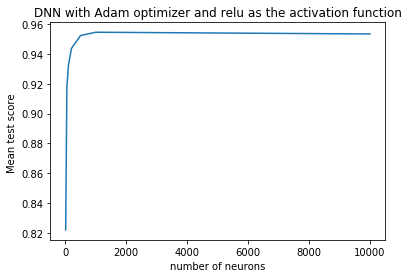

In [12]:
Mean = []

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean in zip(means):
    Mean += [mean]
    
plt.plot(num_neurons, Mean)
plt.xlabel('number of neurons')
plt.ylabel('Mean test score ')
plt.title('DNN with Adam optimizer and relu as the activation function')


## Creating CNNs with Keras


We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. This approach neglects any spatial structure in the image. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [33]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (40000, 28, 28, 1)
Y_train shape: (40000, 10)

40000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers. Luckily, all we need to do is change the architecture of our DNN.


After we instantiate the model, add the first convolutional layer with 10 filters, which is the dimensionality of output space. (https://keras.io/layers/convolutional/) Here, we will be concerned with local spatial filters
that take as inputs a small spatial patch of the
previous layer at all depths. We consider a three-dimensional kernel of size $5\times5\times1$. Check out this visualization of the
convolution procedure for a square input of unit depth: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
The convolution consists of running this filter over all locations
in the spatial plane. After computing the filter, the output is passed through
a non-linearity, a ReLU.

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(10, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))

Subsequently, add a 2D pooling layer. (https://keras.io/layers/pooling/) This pooling layer coarse-grain spatial information by performing
a subsampling at each depth. Here, we use the max pool operation. In a max pool, the spatial
dimensions are coarse-grained by replacing a small region
(say $2\times2$ neurons) by a single neuron whose output is the
maximum value of the output in the region.

In [10]:
model.add(MaxPooling2D(pool_size=(2, 2)))

We add another convolutional layers with 20 filters and apply dropout. Then, wa add another pooling layer and flatten the data.

In [12]:
# add second convolutional layer with 20 filters
model.add(Conv2D(20, (5, 5), activation='relu'))
# apply dropout with rate 0.5
model.add(Dropout(0.5))
# add 2D pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten data
model.add(Flatten())
# add a dense all-to-all relu layer
model.add(Dense(20*4*4, activation='relu'))
# apply dropout with rate 0.5
model.add(Dropout(0.5))
# soft-max layer
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
keep_dims is deprecated, use keepdims instead



Lastly, train your CNN and evaluate the model.

In [13]:
# training parameters
batch_size = 64
epochs = 10


# train CNN
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 40000 samples, validate on 10000 samples
Epoch 1/10




40000/40000 [==============================] - 14s - loss: 0.3360 - acc: 0.8945 - val_loss: 0.1114 - val_acc: 0.9784
Epoch 2/10
40000/40000 [==============================] - 13s - loss: 0.1083 - acc: 0.9664 - val_loss: 0.0599 - val_acc: 0.9854
Epoch 3/10
40000/40000 [==============================] - 13s - loss: 0.0790 - acc: 0.9756 - val_loss: 0.0614 - val_acc: 0.9859
Epoch 4/10
40000/40000 [==============================] - 14s - loss: 0.0651 - acc: 0.9797 - val_loss: 0.0507 - val_acc: 0.9870
Epoch 5/10
40000/40000 [==============================] - 13s - loss: 0.0569 - acc: 0.9824 - val_loss: 0.0387 - val_acc: 0.9906
Epoch 6/10
40000/40000 [==============================] - 13s - loss: 0.0515 - acc: 0.9845 

<span style="color:blue"> <i> We do the grid search over any 3 different optimization schemes and 2 activation functions. Suppose that we have a 2 convolutional layers with 10 neurons. Let p_dropout = 0.5, epochs = 1, and batch_size = 64. We then determine which combination of optimization scheme, activation function, and number of neurons gives the best accuracy. </i></span> <br>

In [20]:
def DNN(activation='relu', optimizer='Adam'):
    model = Sequential()
    model.add(Conv2D(10, (5, 5), activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(10, (5, 5), activation=activation))
    model.add(Dropout(0.5))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

    return model


batch_size = 64
epochs = 1
model_gridsearch = KerasClassifier(build_fn=DNN, 
                        epochs=epochs, batch_size=batch_size, verbose=1)

# define parameter dictionary
optimizer = ['SGD', 'Adam', 'Adamax']
activation = ['relu', 'elu']
param_grid = dict(optimizer=optimizer, activation=activation)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,Y_train)   

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/1
10000/10000 [==============================] - 1s     
Epoch 1/1
10000/10000 [==============================] - 2s     
Epoch 1/1
10000/10000 [==============================] - 2s     
Epoch 1/1
40000/40000 [==============================] - 12s - loss: 0.5395 - acc: 0.8297    
Best: 0.949825 using {'activation': 'relu', 'optimizer': 'Adam'}


In [21]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.949825 using {'activation': 'relu', 'optimizer': 'Adam'}


<span style="color:blue"> <i> Then, we create an arbitrary DNN (you are free to choose any activation function, optimization scheme, etc) and evaluate its performance. Then, we add two convolutional layers and pooling layers and evaluate its performance again. </i></span> <br>

In [15]:
def create_DNN_6():
    model = Sequential()
    model.add(Dense(10,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dropout(0.5))
    return model

model = create_DNN_6()
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

batch_size = 64
epochs = 1


# train CNN
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score_1 = model.evaluate(X_test, Y_test, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 8864/10000 [=========================>....] - ETA: 0s

In [17]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (40000, 28, 28, 1)
Y_train shape: (40000, 10)

40000 train samples
10000 test samples


In [23]:
batch_size = 64
epochs = 1

model = Sequential()
model.add(Conv2D(10, (5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, (5, 5), activation='relu'))
model.add(Dropout(0.5))
# add 2D pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten data
model.add(Flatten())
model.add(Dense(10,input_shape=(img_rows*img_cols,), activation='relu'))
model.add(Dropout(0.5))
# add a dense all-to-all relu layer
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

score_2 = model.evaluate(X_test, Y_test, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 9824/10000 [============================>.] - ETA: 0s

### Results 

In [25]:
print('Test loss without conventional layers:', score_1[0])
print('Test accuracy without conventional layers:', score_1[1])
print('Test loss with conventional layers:', score_2[0])
print('Test accuracy with conventional layers:', score_2[1])

Test loss without conventional layers: 0.7665949113845825
Test accuracy without conventional layers: 0.8537
Test loss with conventional layers: 0.629766546344757
Test accuracy with conventional layers: 0.9225


### Adding conventional layers reduces the loss and increases the accuracy. 